In [2]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag="v0.3.0");
using LinearAlgebra, Statistics, Compat

Question 7: simulates
$$
x_{t+1} = \, \alpha \, x_t + \sigma\, \epsilon_{t+1} \tag{1}
\quad \text{where} \quad
x_0 = 1
\quad \text{and} \quad t = 0,\ldots,t_{\max}
$$

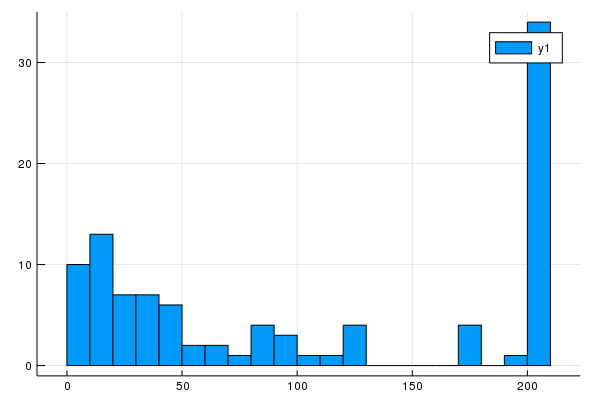

In [4]:
using Parameters
using Plots
gr(fmt=:png)

# simulate directly
function simulatepassage(params)
    @unpack α, σ, t_max, x₀, a = params
    
    x = x₀ # start at the initial condition
    for t in 0:t_max-1
        x = α * x + σ * randn() # (1)
        if x < a
            return t+1           
        end        
    end
    return t_max #if it got here, we left the loop
end

simulatemanypassages(params, N) = [simulatepassage(params) for _ in 1:N]

# setup parameters
paramgen = @with_kw (x₀=1.0, α=1.0, σ=0.2, a=0.0, t_max=200)

# could draw a large number of them
N = 100
bins = 20
params = paramgen() # stick with defaults

histogram(simulatemanypassages(params, N), bins=bins)

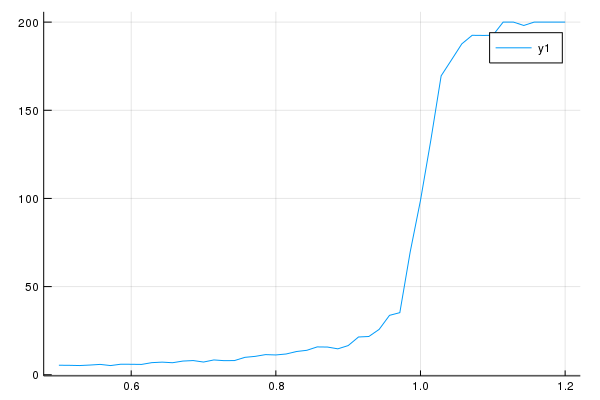

In [6]:
meanpassage(params, N) = mean(simulatemanypassages(params, N))

# if we just want to modify the α
meanpassage(α; N = 100) = mean(simulatemanypassages(paramgen(α=α), N))

numα = 50
α = range(0.5, 1.2, length = numα)
N = 500

# broadcast
plot(α, meanpassage.(α))

In [7]:
# could also calculate other statistics
function passagestatistics(params; N=100)
    passages = simulatemanypassages(params, N)
    (mean = mean(passages), std = std(passages), min = minimum(passages), max = maximum(passages))
end
passagestatistics(paramgen(), N=1000)

(mean = 96.691, std = 77.58866876368302, min = 3, max = 200)

Question 8a

In [8]:
using ForwardDiff

function newtonroot(f, f′; x₀, tolerance = 1E-7, maxiter = 1000)
    # setup the algorithm
    x_old = x₀
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = x_old - f(x_old)/f′(x_old) # use the passed in map
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (root = x_old, normdiff = normdiff, iter = iter) # A named tuple
end

# for auto-differentiation, can just forward to the existing one
D(f) = x -> ForwardDiff.derivative(f, x)

# same name! different parameters
newtonroot(f; x₀, tolerance = 1E-7, maxiter = 1000) = newtonroot(f, D(f), x₀=x₀, tolerance = tolerance, maxiter = maxiter)

newtonroot (generic function with 2 methods)

In [9]:
f(x) = (x-1.0)^3
f′(x) = 3.0*(x-1.0)^2
x₀ = 0.1
@show newtonroot(f, f′, x₀ = x₀)
@show newtonroot(f, x₀ = x₀)

newtonroot(f, f′, x₀=x₀) = (root = 0.9999998168636032, normdiff = 9.156819846811715e-8, iter = 39)
newtonroot(f, x₀=x₀) = (root = 0.9999998168636032, normdiff = 9.156819846811715e-8, iter = 39)


(root = 0.9999998168636032, normdiff = 9.156819846811715e-8, iter = 39)

Can benchmark with @btime

In [11]:
using BenchmarkTools
@btime newtonroot(f, f′, x₀ = x₀)
@btime newtonroot(f, x₀ = x₀)

  1.240 μs (4 allocations: 80 bytes)
  1.370 μs (7 allocations: 144 bytes)


(root = 0.9999998168636032, normdiff = 9.156819846811715e-8, iter = 39)